In [ ]:
import csv
import os
import shutil
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import pandas as pd
from shutil import copyfile
from scipy.io.wavfile import read, write
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import librosa
from scipy.io import wavfile
import librosa.util
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.impute import SimpleImputer

### Convertir el archivo demographic_info a csv

In [ ]:
archivo_txt = 'demographic_info.txt'
archivo_csv = 'demographic_info.csv'

with open(archivo_txt, 'r') as archivo_entrada, open(archivo_csv, 'w', newline='') as archivo_salida:
    lector = csv.reader(archivo_entrada, delimiter=',')
    escritor = csv.writer(archivo_salida, delimiter=',')
    
    for linea in lector:
        escritor.writerow(linea)

### Visualizar las señales de audio


In [125]:
def VisualizarSeñales(folder_path):
    # Ruta de la carpeta que contiene los archivos de audio

    # Obtener la lista de archivos .wav en la carpeta
    file_list = [file for file in os.listdir(folder_path) if file.endswith(".wav")]

    # Recorrer cada archivo de audio
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        
        # Cargar el archivo de audio
        sample_rate, audio_data = wav.read(file_path)
        
        # Crear el vector de tiempo
        duration = len(audio_data) / sample_rate
        time = np.arange(0, duration, 1/sample_rate)
        
        # Graficar la señal de audio
        plt.figure()
        plt.plot(time, audio_data)
        plt.xlabel("Tiempo (s)")
        plt.ylabel("Amplitud")
        plt.title(file_name)
        plt.show()

In [ ]:
VisualizarSeñales("audio_and_txt_files")

### Aumentar la cantidad de datos

In [ ]:
# Directorio donde se encuentran los archivos de audio y anotación
directory = "audio_and_txt_files/"

# Leer el archivo de diagnósticos de los pacientes
diagnosis_df = pd.read_csv("patient_diagnosis.csv")



In [ ]:
# Crear una carpeta para guardar los archivos segmentados por diagnóstico
output_directory = "salida"
os.makedirs(output_directory, exist_ok=True)

# Leer archivos de anotación y crear un DataFrame
annotations = pd.DataFrame(columns=["Filename", "Start", "End", "Crackles", "Wheezes", "Diagnosis"])



In [ ]:
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        annotation_path = os.path.join(directory, filename)
        audio_filename = filename.replace(".txt", ".wav")
        audio_path = os.path.join(directory, audio_filename)

        # Leer el archivo de anotación y extraer información
        with open(annotation_path, "r") as file:
            lines = file.readlines()
            for line in lines:
                start, end, crackles, wheezes = line.split()
                start = float(start)
                end = float(end)
                crackles = int(crackles)
                wheezes = int(wheezes)
                
                # Obtener el número de paciente del nombre del archivo de audio
                patient_number = audio_filename.split("_")[0]
        
                # Obtener el diagnóstico del paciente
                diagnosis = diagnosis_df.loc[diagnosis_df["patient_number"] == int(patient_number), "diagnosis"].values[0]
        
                # Agregar los datos al DataFrame de anotaciones
                annotation_data = pd.DataFrame([[audio_filename, start, end, crackles, wheezes, diagnosis]], columns=["Filename", "Start", "End", "Crackles", "Wheezes", "Diagnosis"])
                annotations = pd.concat([annotations, annotation_data], ignore_index=True)

In [ ]:
# Leer los archivos de audio y segmentar según las anotaciones
for index, row in annotations.iterrows():
    audio_filename = row["Filename"]
    audio_path = os.path.join(directory, audio_filename)
    
    # Leer el archivo de audio
    sample_rate, audio_data = read(audio_path)
    
    # Segmentar el audio según los tiempos de inicio y fin
    start_sample = int(row["Start"] * sample_rate)
    end_sample = int(row["End"] * sample_rate)
    segmented_audio = audio_data[start_sample:end_sample]
    
    # Obtener el diagnóstico del paciente
    diagnosis = row["Diagnosis"]
    
    # Crear la carpeta correspondiente al diagnóstico (si no existe)
    diagnosis_folder = os.path.join(output_directory, diagnosis)
    os.makedirs(diagnosis_folder, exist_ok=True)
    
    # Guardar el archivo segmentado en la carpeta correspondiente
    output_filename = f"{audio_filename}_{index}.wav"  # Nombre único para el archivo segmentado
    output_path = os.path.join(diagnosis_folder, output_filename)
    write(output_path, sample_rate, segmented_audio) 
# Ahora los ciclos de audio indicados en los archivos de texto se han guardado en carpetas correspondientes a los diagnósticos de los pacientes.

### Segmentar una cantidad de datos uniforme para entrenar el modelo

In [ ]:
# Directorio de origen y destino
source_folder = "salida"
destination_folder = "salida-2"

# Lista de diagnósticos
diagnoses = ["Bronchiolitis", "COPD", "Healthy", "Pneumonia", "URTI"]

# Crear la carpeta de destino si no existe
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Recorrer los diagnósticos
for diagnosis in diagnoses:
    # Ruta de la carpeta del diagnóstico
    diagnosis_folder = os.path.join(source_folder, diagnosis)
    
    # Obtener la lista de archivos de audio en la carpeta
    audio_files = os.listdir(diagnosis_folder)
    
    # Seleccionar pseudoaleatoriamente 104 archivos de audio
    selected_files = random.sample(audio_files, 160)
    
    # Mover los archivos seleccionados a la carpeta de destino
    for file in selected_files:
        source_path = os.path.join(diagnosis_folder, file)
        destination_path = os.path.join(destination_folder, diagnosis, file)
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)
        shutil.copy(source_path, destination_path)


### Modelos

#### Random Forest

In [113]:
# Ruta de la carpeta que contiene los archivos de audio
folder_path = "salida-2"

# Lista de diagnósticos
diagnoses = ["Bronchiolitis", "COPD", "Healthy", "Pneumonia", "URTI"]

# Longitud fija para rellenar o truncar los archivos de audio
fixed_length = 44100

# Listas para almacenar los datos de entrenamiento
X = []
y = []

# Recorrer los diagnósticos
for diagnosis in diagnoses:
    # Ruta de la carpeta del diagnóstico
    diagnosis_folder = os.path.join(folder_path, diagnosis)
    
    # Obtener la lista de archivos de audio en la carpeta
    audio_files = os.listdir(diagnosis_folder)
    
    # Recorrer los archivos de audio
    for file in audio_files:
        # Ruta del archivo de audio
        audio_path = os.path.join(diagnosis_folder, file)
        
        # Leer el archivo de audio
        sample_rate, audio_data = wavfile.read(audio_path)
        
        # Rellenar o truncar el archivo de audio para tener una longitud fija
        if len(audio_data) < fixed_length:
            audio_data = np.pad(audio_data, (0, fixed_length - len(audio_data)), mode='constant')
        elif len(audio_data) > fixed_length:
            audio_data = audio_data[:fixed_length]
        
        # Agregar los datos de audio a la lista X
        X.append(audio_data)
        
        # Agregar la etiqueta del diagnóstico a la lista y
        y.append(diagnosis)

# Convertir las listas X y y a matrices numpy
X = np.array(X)
y = np.array(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Entrenar un modelo de Random Forest
model_rf = RandomForestClassifier(n_estimators=45, random_state=25)
model_rf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model_rf.predict(X_test)

# Calcular la precisión del modelo
AccuracyRandomForest = accuracy_score(y_test, y_pred)
print("Precisión del modelo: {:.2f}%".format(AccuracyRandomForest * 100))

Precisión del modelo: 31.87%


#### Support Vector Machines (SVM)

In [114]:
# Ruta de la carpeta que contiene los archivos de audio
folder_path = "salida-2"

# Lista de diagnósticos
diagnoses = ["Bronchiolitis", "COPD", "Healthy", "Pneumonia", "URTI"]

# Longitud fija para rellenar o truncar los archivos de audio
fixed_length = 44100

# Listas para almacenar los datos de entrenamiento
X = []
y = []

# Recorrer los diagnósticos
for diagnosis in diagnoses:
    # Ruta de la carpeta del diagnóstico
    diagnosis_folder = os.path.join(folder_path, diagnosis)
    
    # Obtener la lista de archivos de audio en la carpeta
    audio_files = os.listdir(diagnosis_folder)
    
    # Recorrer los archivos de audio
    for file in audio_files:
        # Ruta del archivo de audio
        audio_path = os.path.join(diagnosis_folder, file)
        
        # Leer el archivo de audio
        sample_rate, audio_data = wavfile.read(audio_path)
        
        # Rellenar o truncar el archivo de audio para tener una longitud fija
        if len(audio_data) < fixed_length:
            audio_data = np.pad(audio_data, (0, fixed_length - len(audio_data)), mode='constant')
        elif len(audio_data) > fixed_length:
            audio_data = audio_data[:fixed_length]
        
        # Agregar los datos de audio a la lista X
        X.append(audio_data)
        
        # Agregar la etiqueta del diagnóstico a la lista y
        y.append(diagnosis)

# Convertir las listas X y y a matrices numpy
X = np.array(X)
y = np.array(y)

# Entrenar un modelo de Support Vector Machine (SVM)
model_svm = SVC(random_state=10)
model_svm.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model_svm.predict(X_test)

# Calcular la precisión del modelo
AccuracySVM = accuracy_score(y_test, y_pred)
print("Precisión del modelo: {:.2f}%".format(AccuracySVM * 100))

Precisión del modelo: 33.12%


#### Redes Neuronales Convolucionales (CNN)

In [121]:
# Ruta de la carpeta que contiene los archivos de audio
folder_path = "salida-2"

# Lista de diagnósticos
diagnoses = ["Bronchiolitis", "COPD", "Healthy", "Pneumonia", "URTI"]

# Longitud fija para rellenar o truncar los archivos de audio
fixed_length = 44100

# Listas para almacenar los datos de entrenamiento
X = []
y = []

# Recorrer los diagnósticos
for diagnosis in diagnoses:
    # Ruta de la carpeta del diagnóstico
    diagnosis_folder = os.path.join(folder_path, diagnosis)
    
    # Obtener la lista de archivos de audio en la carpeta
    audio_files = os.listdir(diagnosis_folder)
    
    # Recorrer los archivos de audio
    for file in audio_files:
        # Ruta del archivo de audio
        audio_path = os.path.join(diagnosis_folder, file)
        
        # Leer el archivo de audio
        sample_rate, audio_data = wavfile.read(audio_path)
        
        # Rellenar o truncar el archivo de audio para tener una longitud fija
        if len(audio_data) < fixed_length:
            audio_data = np.pad(audio_data, (0, fixed_length - len(audio_data)), mode='constant')
        elif len(audio_data) > fixed_length:
            audio_data = audio_data[:fixed_length]
        
        # Agregar los datos de audio a la lista X
        X.append(audio_data)
        
        # Agregar la etiqueta del diagnóstico a la lista y
        y.append(diagnosis)

# Convertir las listas X y y a matrices numpy
X = np.array(X)
y = np.array(y)

# Codificar las etiquetas de clase
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Normalizar los datos de entrada
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape de los datos para que tengan la forma (número de muestras, longitud de audio, 1)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Construir el modelo de CNN
model_cnn = Sequential()
model_cnn.add(Conv1D(32, 3, activation='relu', input_shape=(fixed_length, 1)))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(64, 3, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(len(diagnoses), activation='softmax'))

# Compilar el modelo
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluar el modelo en el conjunto de prueba
_, accuracy = model_cnn.evaluate(X_test, y_test)
AccuracyCNN = accuracy
print("Precisión del modelo: {:.2f}%".format(AccuracyCNN * 100))


Epoch 1/10
20/20 [==============================] - 20s 932ms/step - loss: 13070742.0000 - accuracy: 0.1875 - val_loss: 586911.1875 - val_accuracy: 0.2250
Epoch 2/10
20/20 [==============================] - 19s 937ms/step - loss: 137028.9688 - accuracy: 0.2078 - val_loss: 69.4681 - val_accuracy: 0.2000
Epoch 3/10
20/20 [==============================] - 18s 920ms/step - loss: 1009.9014 - accuracy: 0.2062 - val_loss: 1.6104 - val_accuracy: 0.2000
Epoch 4/10
20/20 [==============================] - 18s 918ms/step - loss: 974.8244 - accuracy: 0.2078 - val_loss: 74.3071 - val_accuracy: 0.2000
Epoch 5/10
20/20 [==============================] - 18s 922ms/step - loss: 3.2492 - accuracy: 0.2078 - val_loss: 81.2276 - val_accuracy: 0.2000
Epoch 6/10
20/20 [==============================] - 18s 917ms/step - loss: 1.5968 - accuracy: 0.2078 - val_loss: 79.7492 - val_accuracy: 0.2000
Epoch 7/10
20/20 [==============================] - 18s 909ms/step - loss: 1.5968 - accuracy: 0.2094 - val_loss: 79.

#### Series de tiempo con parametros estadisticos

In [119]:
# Ruta de la carpeta que contiene los archivos de audio
folder_path = "salida-2"

# Lista de diagnósticos
diagnoses = ["Bronchiolitis", "COPD", "Healthy", "Pneumonia", "URTI"]

# Listas para almacenar las características y etiquetas
features = []
labels = []

# Recorrer los diagnósticos
for diagnosis in diagnoses:
    # Ruta de la carpeta del diagnóstico
    diagnosis_folder = os.path.join(folder_path, diagnosis)
    
    # Obtener la lista de archivos de audio en la carpeta
    audio_files = os.listdir(diagnosis_folder)
    
    # Recorrer los archivos de audio
    for file in audio_files:
        # Ruta del archivo de audio
        audio_path = os.path.join(diagnosis_folder, file)
        
        # Leer el archivo de audio
        sample_rate, audio_data = wavfile.read(audio_path)
        
        # Obtener las características de la serie de tiempo (media y desviación estándar)
        time_series_mean = np.mean(audio_data)
        time_series_std = np.std(audio_data)
        
        # Agregar las características a la lista de características
        features.append([time_series_mean, time_series_std])
        
        # Agregar la etiqueta del diagnóstico a la lista de etiquetas
        labels.append(diagnosis)

# Convertir las listas de características y etiquetas a matrices numpy
X = np.array(features)
y = np.array(labels)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# Entrenar un modelo de Random Forest
model_ts = RandomForestClassifier(n_estimators=45, random_state=25)
model_ts.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model_ts.predict(X_test)

# Calcular la precisión del modelo
AccuracyTS = accuracy_score(y_test, y_pred)
print("Precisión del modelo: {:.2f}%".format(AccuracyTS * 100))


Precisión del modelo: 38.75%


#### Serie de tiempo con tranformada de furier

In [129]:
# Ruta de la carpeta que contiene los archivos de audio
folder_path = "salida-2"

# Lista de diagnósticos
diagnoses = ["Bronchiolitis", "COPD", "Healthy", "Pneumonia", "URTI"]

# Parámetros para la transformada de Fourier
n_fft = 2048  # Tamaño de la ventana de análisis
hop_length = 512  # Desplazamiento entre ventanas

# Lista para almacenar las características y etiquetas
features = []
labels = []

# Recorrer los diagnósticos
for diagnosis in diagnoses:
    # Ruta de la carpeta del diagnóstico
    diagnosis_folder = os.path.join(folder_path, diagnosis)
    
    # Obtener la lista de archivos de audio en la carpeta
    audio_files = os.listdir(diagnosis_folder)
    
    # Recorrer los archivos de audio
    for file in audio_files:
        # Ruta del archivo de audio
        audio_path = os.path.join(diagnosis_folder, file)
        
        # Leer el archivo de audio y obtener la duración
        sample_rate, audio_data = wavfile.read(audio_path)
        
        # Convertir los datos de audio a punto flotante
        audio_data = audio_data.astype(np.float32) / np.iinfo(audio_data.dtype).max
        
        # Calcular la transformada de Fourier de la serie de tiempo
        audio_fft = np.abs(librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length))
        
        # Aplanar la matriz de amplitudes de la transformada de Fourier
        audio_fft_flat = audio_fft.flatten()
        
        # Agregar las características a la lista de características
        features.append(audio_fft_flat)
        
        # Agregar la etiqueta del diagnóstico a la lista de etiquetas
        labels.append(diagnosis)

# Crear un DataFrame para almacenar las características y etiquetas
df = pd.DataFrame(features)
df['label'] = labels

# Obtener las características y etiquetas del DataFrame
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Imputar valores NaN utilizando la estrategia de reemplazo por la media
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Entrenar un modelo de Random Forest
model_tsf = RandomForestClassifier(n_estimators=45, random_state=25)
model_tsf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model_tsf.predict(X_test)

# Calcular la precisión del modelo
AccuracyTSF = accuracy_score(y_test, y_pred)
print("Precisión del modelo: {:.2f}%".format(AccuracyTSF * 100))


Precisión del modelo: 62.50%


In [128]:
print(audio_fft_flat)

[2.95298889e+01 5.34074583e+01 4.32524850e+01 ... 8.94154892e-04
 4.72624366e-03 2.24859342e-02]


### Graficar

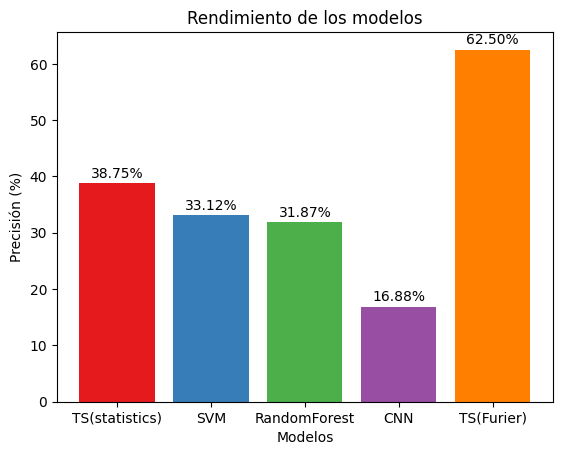

In [130]:
Accuracys = [AccuracyTS, AccuracySVM, AccuracyRandomForest, AccuracyCNN , AccuracyTSF]
ModelNames = ["TS(statistics)", "SVM", "RandomForest", "CNN", "TS(Furier)"]
num_bars = len(Accuracys)

plt.bar(ModelNames, [score * 100 for score in Accuracys], color=plt.cm.Set1(range(num_bars)))
plt.xlabel("Modelos")
plt.ylabel("Precisión (%)")
plt.title("Rendimiento de los modelos")
#plt.xticks(rotation=45)
for i in range(num_bars):
    plt.text(i, Accuracys[i] * 100 + 1, f"{Accuracys[i] * 100:.2f}%", ha='center')
plt.show()

### Predecir resultados de nuevos datos

In [136]:
# Ruta del archivo de audio nuevo
new_audio_path = "salida/Pneumonia/122_2b1_Ar_mc_LittC2SE.wav_875.wav"
# Leer el archivo de audio nuevo
sample_rate, audio_data = wavfile.read(new_audio_path)

# Rellenar o truncar el archivo de audio para tener una longitud fija
if len(audio_data) < fixed_length:
    audio_data = np.pad(audio_data, (0, fixed_length - len(audio_data)), mode='constant')
elif len(audio_data) > fixed_length:
    audio_data = audio_data[:fixed_length]

# Convertir el audio a un arreglo unidimensional
audio_data = audio_data.flatten()

# Preprocesar el audio de la misma manera que los datos de entrenamiento
new_audio = np.array([audio_data])

# Leer el archivo de audio nuevo
sample_rate, audio_data = wavfile.read(new_audio_path)

# Obtener las características de la serie de tiempo (media y desviación estándar)
time_series_mean = np.mean(audio_data)
time_series_std = np.std(audio_data)

# Crear un arreglo con las características del nuevo audio
new_audio_features = np.array([[time_series_mean, time_series_std]])

# Realizar la predicción en el audio nuevo
predicted_diagnosis_rf = model_rf.predict(new_audio)
predicted_diagnosis_svm = model_svm.predict(new_audio)
#predicted_diagnosis_cnn = model_cnn.predict(new_audio)
predicted_diagnosis_ts = model_ts.predict(new_audio_features)

# Imprimir el diagnóstico predicho
print("El diagnóstico del audio por Random Forest es:", predicted_diagnosis_rf)
print("El diagnóstico del audio por SVM es:", predicted_diagnosis_svm)
#print("El diagnóstico del audio por CNN es:", predicted_diagnosis_cnn)
print("El diagnóstico del audio por Series de tiempo con parametros estadisticos y random forest es:", predicted_diagnosis_ts)



El diagnóstico del audio por Random Forest es: ['Healthy']
El diagnóstico del audio por SVM es: ['Bronchiolitis']
El diagnóstico del audio por Series de tiempo con parametros estadisticos y random forest es: ['Pneumonia']
